In [1]:
#!pip install -e .. datasets sympy numpy matplotlib seaborn -q  # Install dev version of smolagents + some packages
#!export HF_TOKEN=

In [2]:
from datetime import datetime


# Benchmark date
# - set a concrete date:
DATE = "2025-07-17"
# - or use default: today
# DATE = None
# DATE = DATE or datetime.date.today().isoformat()

# Evaluation dataset
# - the dataset is gated, so you must first visit its page to request access: https://huggingface.co/datasets/smolagents-benchmark/benchmark-v1
EVAL_DATASET = "smolagents/benchmark-v1"

# Answers dataset: it must be a gated dataset; required to score the answers
ANSWERS_DATASET = "smolagents/answers"
# Whether to push the answers dataset to the Hub
PUSH_ANSWERS_DATASET_TO_HUB = True

# Results dataset
RESULTS_DATASET = "smolagents/results"
# Whether to push the results dataset to the Hub
PUSH_RESULTS_DATASET_TO_HUB = False

## Constants and utilities/tools

In [3]:
import re
import string
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
from tqdm import tqdm


def normalize_number_str(number_str: str) -> float:
    # we replace these common units and commas to allow
    # conversion to float
    for char in ["$", "%", ","]:
        number_str = number_str.replace(char, "")
    try:
        return float(number_str)
    except ValueError:
        return float("inf")


def split_string(
    s: str,
    char_list: list[str] = [",", ";"],
) -> list[str]:
    pattern = f"[{''.join(char_list)}]"
    return re.split(pattern, s)


def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False


def normalize_str(input_str, remove_punct=True) -> str:
    """
    Normalize a string by:
    - Removing all white spaces
    - Optionally removing punctuation (if remove_punct is True)
    - Converting to lowercase
    Parameters:
    - input_str: str, the string to normalize
    - remove_punct: bool, whether to remove punctuation (default: True)
    Returns:
    - str, the normalized string
    """
    # Remove all white spaces. Required e.g for seagull vs. sea gull
    no_spaces = re.sub(r"\s", "", input_str)

    # Remove punctuation, if specified.
    if remove_punct:
        translator = str.maketrans("", "", string.punctuation)
        return no_spaces.lower().translate(translator)
    else:
        return no_spaces.lower()


def extract_numbers(text: str) -> list[str]:
    """This pattern matches:
    - Optional negative sign
    - Numbers with optional comma thousand separators
    - Optional decimal points with decimal numbers
    """
    pattern = r"-?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?"

    return [el.replace(",", "") for el in re.findall(pattern, text)]


def get_question_score_gaia(
    model_answer: str,
    ground_truth: str,
) -> bool:
    """Scoring function used to score functions from the GAIA benchmark"""
    if is_float(ground_truth):
        normalized_answer = normalize_number_str(str(model_answer))
        return normalized_answer == float(ground_truth)

    elif any(char in ground_truth for char in [",", ";"]):  # if gt is a list
        # question with the fish: normalization removes punct
        gt_elems = split_string(ground_truth)
        ma_elems = split_string(model_answer)

        if len(gt_elems) != len(ma_elems):  # check length is the same
            warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
            return False

        comparisons = []
        for ma_elem, gt_elem in zip(ma_elems, gt_elems):  # compare each element as float or str
            if is_float(gt_elem):
                normalized_ma_elem = normalize_number_str(ma_elem)
                comparisons.append(normalized_ma_elem == float(gt_elem))
            else:
                # we do not remove punct since comparisons can include punct
                comparisons.append(
                    normalize_str(ma_elem, remove_punct=False) == normalize_str(gt_elem, remove_punct=False)
                )
        return all(comparisons)

    else:  # if gt is a str
        return normalize_str(model_answer) == normalize_str(ground_truth)


def get_correct(row):
    if row["source"] == "MATH":  # Checks the last number in answer
        numbers_answer = extract_numbers(str(row["answer"]))
        if len(numbers_answer) == 0:
            return False
        return np.isclose(float(numbers_answer[-1]), float(row["true_answer"]), rtol=1e-5, atol=1e-7)
    else:
        return get_question_score_gaia(str(row["answer"]), str(row["true_answer"]))


def score_answers_subset(answers_dataset, answers_subset):
    try:
        print(answers_dataset, answers_subset)
        *model_id, action_type, task = answers_subset.split("__")
        model_id = "/".join(model_id)
        ds = datasets.load_dataset(answers_dataset, answers_subset, split="test")
        df = ds.to_pandas()
        df["correct"] = df.apply(get_correct, axis=1)
        assert df["correct"].notnull().sum() > 30, "Missing answers"
        acc = df["correct"].mean().item()
        result = df.loc[0, ["model_id", "agent_action_type", "source"]].to_dict()
        result["acc"] = acc
        return result
    except Exception as e:
        print(f"Error with {answers_subset}: {e}")
        return None


def score_answers(
    answers_subsets,
    answers_dataset=ANSWERS_DATASET,
    date=DATE,
    push_to_hub_dataset=RESULTS_DATASET if PUSH_RESULTS_DATASET_TO_HUB else None,
    set_default=True,
):
    """
    Score answers from the given dataset subsets.

    Parameters:
        answers_subsets: List of dataset subsets to score
        answers_dataset: Dataset containing the answers
        date: Date to use for the config name
        push_to_hub_dataset: Dataset ID to push results to, or None to skip pushing
        set_default: If True, sets this config as the default config in the Hugging Face Hub dataset.
                     This means when users load the dataset without specifying a config,
                     this version will be loaded by default.
    """
    if not answers_dataset:
        raise ValueError("Pass 'answers_dataset' to load the answers from it")
    date = date or datetime.date.today().isoformat()
    results = []
    with ThreadPoolExecutor(max_workers=16) as exe:
        futures = [
            exe.submit(score_answers_subset, answers_dataset, answers_subset) for answers_subset in answers_subsets
        ]
        for f in tqdm(as_completed(futures), total=len(answers_subsets), desc="Processing tasks"):
            result = f.result()
            if result:
                results.append(result)
    df = pd.DataFrame(results)

    if push_to_hub_dataset:
        ds = datasets.Dataset.from_pandas(df)
        config = date
        ds.push_to_hub(
            push_to_hub_dataset, config_name=config, commit_message=f"Upload {config} results", create_pr=True
        )
        # ds.push_to_hub(push_to_hub_dataset, config_name=config, commit_message=f"Upload {config} results")
    return df

## Score answers

In [4]:
import datasets
import pandas as pd


# Choose the answers subsets to score:
# answers_subsets = ["meta-llama__Llama-3.1-8B-Instruct__code__gaia"]
# or get all the answers subsets present in the ANSWERS_DATASET
answers_subsets = datasets.get_dataset_config_names(ANSWERS_DATASET)
print("Number of answers_subsets", len(answers_subsets))
print("Example of answers_subset", answers_subsets[0])

result_df = score_answers(answers_subsets)
result_df["acc"] = (result_df["acc"] * 100).round(2)
result_df.head()

/home/ecca/GitFiles/dec_smolagents/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of answers_subsets 129
Example of answers_subset Qwen__QwQ-32B__code__gaia
smolagents/answers Qwen__QwQ-32B__code__gaia
smolagents/answers Qwen__QwQ-32B__code__math
smolagents/answers Qwen__QwQ-32B__code__simpleqa
smolagents/answers Qwen__Qwen2.5-72B-Instruct__code__gaia
smolagents/answers Qwen__Qwen2.5-72B-Instruct__code__math
smolagents/answers Qwen__Qwen2.5-72B-Instruct__code__simpleqa
smolagents/answers Qwen__Qwen2.5-72B-Instruct__vanilla__gaia
smolagents/answers Qwen__Qwen2.5-72B-Instruct__vanilla__math
smolagents/answers Qwen__Qwen2.5-72B-Instruct__vanilla__simpleqa
smolagents/answers Qwen__Qwen2.5-7B-Instruct__vanilla__gaia
smolagents/answers Qwen__Qwen2.5-7B-Instruct__vanilla__math
smolagents/answers Qwen__Qwen2.5-7B-Instruct__vanilla__simpleqa
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__code__gaia
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__code__math
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__code__simpleqa
smolagents/answers Qwen__Qwen2.5-C

Processing tasks:   1%|          | 1/129 [00:07<16:56,  7.94s/it]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:   4%|▍         | 5/129 [00:08<02:30,  1.21s/it]

smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__tool-calling__math
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__tool-calling__simpleqa
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__vanilla__gaia
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__vanilla__math
smolagents/answers Qwen__Qwen2.5-Coder-32B-Instruct__vanilla__simpleqa


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:   5%|▌         | 7/129 [00:08<01:37,  1.25it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:   8%|▊         | 10/129 [00:08<00:55,  2.14it/s]

smolagents/answers Qwen__Qwen3-235B-A22B__code__gaia
smolagents/answers Qwen__Qwen3-235B-A22B__code__math
smolagents/answers Qwen__Qwen3-235B-A22B__code__simpleqa
smolagents/answers Qwen__Qwen3-32B__code__gaia
smolagents/answers Qwen__Qwen3-32B__code__math


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers Qwen__Qwen3-32B__code__simpleqa


Processing tasks:   9%|▉         | 12/129 [00:09<00:56,  2.06it/s]

smolagents/answers anthropic__claude-3-5-sonnet-latest__code__gaia


Processing tasks:  10%|█         | 13/129 [00:11<01:26,  1.34it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  11%|█         | 14/129 [00:11<01:12,  1.59it/s]

smolagents/answers anthropic__claude-3-5-sonnet-latest__code__math
smolagents/answers anthropic__claude-3-5-sonnet-latest__code__simpleqa
smolagents/answers anthropic__claude-3-5-sonnet-latest__tool-calling__gaia


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  12%|█▏        | 16/129 [00:12<01:00,  1.86it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers anthropic__claude-3-5-sonnet-latest__tool-calling__math
smolagents/answers anthropic__claude-3-5-sonnet-latest__tool-calling__simpleqa
smolagents/answers anthropic__claude-3-5-sonnet-latest__vanilla__gaia
smolagents/answers anthropic__claude-3-5-sonnet-latest__vanilla__math
smolagents/answers anthropic__claude-3-5-sonnet-latest__vanilla__simpleqa
smolagents/answers anthropic__claude-3-7-sonnet-20250219__code__gaia


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  17%|█▋        | 22/129 [00:12<00:26,  4.07it/s]

smolagents/answers anthropic__claude-3-7-sonnet-20250219__code__math
smolagents/answers anthropic__claude-3-7-sonnet-20250219__code__simpleqa


Processing tasks:  19%|█▊        | 24/129 [00:15<00:48,  2.18it/s]

smolagents/answers anthropic__claude-3-7-sonnet__code__gaia
smolagents/answers anthropic__claude-3-7-sonnet__code__math


Processing tasks:  20%|██        | 26/129 [00:16<00:49,  2.09it/s]

smolagents/answers anthropic__claude-3-7-sonnet__code__simpleqa
smolagents/answers anthropic__claude-opus-4-20250514__code__gaia
smolagents/answers anthropic__claude-opus-4-20250514__code__math
smolagents/answers anthropic__claude-opus-4-20250514__code__simpleqa
smolagents/answers anthropic__claude-sonnet-4-20250514__code__gaia
smolagents/answers anthropic__claude-sonnet-4-20250514__code__math


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  25%|██▍       | 32/129 [00:16<00:24,  3.92it/s]

smolagents/answers anthropic__claude-sonnet-4-20250514__code__simpleqa



Processing tasks:  26%|██▋       | 34/129 [00:18<00:39,  2.41it/s]

Error with anthropic__claude-3-7-sonnet__code__math: [{'expected': SplitInfo(name='test', num_bytes=5828160, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__code__gaia
Error with anthropic__claude-3-7-sonnet__code__gaia: [{'expected': SplitInfo(name='test', num_bytes=3798372, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__code__math
smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__code__simpleqa


Processing tasks:  28%|██▊       | 36/129 [00:18<00:32,  2.84it/s]

smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__tool-calling__gaia


Processing tasks:  29%|██▊       | 37/129 [00:20<00:43,  2.10it/s]

smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__tool-calling__math


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

smolagents/answers deepseek-ai__DeepSeek-R1-Distill-Qwen-32B__tool-calling__simpleqa



Processing tasks:  30%|███       | 39/129 [00:20<00:40,  2.23it/s]

smolagents/answers deepseek-ai__DeepSeek-R1__code__gaia
smolagents/answers deepseek-ai__DeepSeek-R1__code__math
Error with anthropic__claude-3-7-sonnet__code__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=5770703, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers deepseek-ai__DeepSeek-R1__code__simpleqa


Processing tasks:  33%|███▎      | 42/129 [00:22<00:38,  2.25it/s]

smolagents/answers deepseek-ai__DeepSeek-R1__tool-calling__gaia
smolagents/answers deepseek-ai__DeepSeek-R1__tool-calling__math
smolagents/answers deepseek-ai__DeepSeek-R1__tool-calling__simpleqa


Processing tasks:  34%|███▍      | 44/129 [00:22<00:29,  2.88it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  35%|███▍      | 45/129 [00:22<00:28,  2.96it/s]

smolagents/answers gpt-4.5-preview__code__gaia
smolagents/answers gpt-4.5-preview__code__math


Processing tasks:  37%|███▋      | 48/129 [00:24<00:35,  2.28it/s]

smolagents/answers gpt-4.5-preview__code__simpleqa
smolagents/answers gpt-4.5-preview__vanilla__gaia
smolagents/answers gpt-4.5-preview__vanilla__math
smolagents/answers gpt-4.5-preview__vanilla__simpleqa



Processing tasks:  40%|███▉      | 51/129 [00:26<00:37,  2.10it/s]

Error with deepseek-ai__DeepSeek-R1__tool-calling__math: [{'expected': SplitInfo(name='test', num_bytes=4380804, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers meta-llama__Llama-3.1-70B-Instruct__code__gaia
Error with deepseek-ai__DeepSeek-R1__tool-calling__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=4328100, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers meta-llama__Llama-3.1-70B-Instruct__code__math
smolagents/answers meta-llama__Llama-3.1-70B-Instruct__code__simpleqa


Processing tasks:  42%|████▏     | 54/129 [00:26<00:23,  3.13it/s]

smolagents/answers meta-llama__Llama-3.1-70B-Instruct__tool-calling__gaia


Processing tasks:  43%|████▎     | 55/129 [00:28<00:38,  1.94it/s]

smolagents/answers meta-llama__Llama-3.1-70B-Instruct__tool-calling__math
smolagents/answers meta-llama__Llama-3.1-70B-Instruct__tool-calling__simpleqa
smolagents/answers meta-llama__Llama-3.1-8B-Instruct__code__gaia
smolagents/answers meta-llama__Llama-3.1-8B-Instruct__code__math


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  46%|████▌     | 59/129 [00:29<00:30,  2.27it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  48%|████▊     | 62/129 [00:29<00:20,  3.26it/s]

smolagents/answers meta-llama__Llama-3.1-8B-Instruct__code__simpleqa
smolagents/answers meta-llama__Llama-3.1-8B-Instruct__tool-calling__gaia
smolagents/answers meta-llama__Llama-3.1-8B-Instruct__tool-calling__math
smolagents/answers meta-llama__Llama-3.1-8B-Instruct__tool-calling__simpleqa


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers meta-llama__Llama-3.1-8B-Instruct__vanilla__gaia


Processing tasks:  50%|████▉     | 64/129 [00:31<00:31,  2.08it/s]

smolagents/answers meta-llama__Llama-3.1-8B-Instruct__vanilla__math


Processing tasks:  50%|█████     | 65/129 [00:31<00:28,  2.26it/s]

smolagents/answers meta-llama__Llama-3.1-8B-Instruct__vanilla__simpleqa


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  51%|█████     | 66/129 [00:32<00:25,  2.46it/s]

smolagents/answers meta-llama__Llama-3.2-3B-Instruct__code__gaia


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  52%|█████▏    | 67/129 [00:33<00:35,  1.77it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers meta-llama__Llama-3.2-3B-Instruct__code__math
smolagents/answers meta-llama__Llama-3.2-3B-Instruct__code__simpleqa
smolagents/answers meta-llama__Llama-3.2-3B-Instruct__vanilla__gaia
smolagents/answers meta-llama__Llama-3.2-3B-Instruct__vanilla__math
smolagents/answers meta-llama__Llama-3.2-3B-Instruct__vanilla__simpleqa


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  56%|█████▌    | 72/129 [00:34<00:18,  3.12it/s]

smolagents/answers meta-llama__Llama-3.3-70B-Instruct__code__gaia


Processing tasks:  57%|█████▋    | 73/129 [00:35<00:24,  2.30it/s]

smolagents/answers meta-llama__Llama-3.3-70B-Instruct__code__math
smolagents/answers meta-llama__Llama-3.3-70B-Instruct__code__simpleqa
smolagents/answers meta-llama__Llama-3.3-70B-Instruct__vanilla__gaia


Processing tasks:  62%|██████▏   | 80/129 [00:36<00:13,  3.67it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers meta-llama__Llama-3.3-70B-Instruct__vanilla__math
Error with deepseek-ai__DeepSeek-R1__tool-calling__gaia: [{'expected': SplitInfo(name='test', num_bytes=2866077, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers meta-llama__Llama-3.3-70B-Instruct__vanilla__simpleqa
smolagents/answers meta-llama__Llama-4-Maverick-17B-128E-Instruct__code__gaia
smolagents/answers meta-llama__Llama-4-Maverick-17B-128E-Instruct__code__math
smolagents/answers meta-llama__Llama-4-Maverick-17B-128E-Instruct__code__simpleqa
smolagents/answers meta-llama__Llama-4-Scout-17B-16E-Instruct__code__gaia


Processing tasks:  64%|██████▎   | 82/129 [00:39<00:23,  1.97it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers meta-llama__Llama-4-Scout-17B-16E-Instruct__code__math
smolagents/answers meta-llama__Llama-4-Scout-17B-16E-Instruct__code__simpleqa


Processing tasks:  65%|██████▌   | 84/129 [00:40<00:24,  1.87it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  68%|██████▊   | 88/129 [00:40<00:13,  3.07it/s]

smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__code__gaia
smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__code__math
smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__code__simpleqa
smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__vanilla__gaia
smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__vanilla__math
smolagents/answers mistralai__Mistral-Nemo-Instruct-2407__vanilla__simpleqa
smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__code__gaia


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  72%|███████▏  | 93/129 [00:43<00:13,  2.63it/s]

smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__code__math
smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__code__simpleqa
smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__gaia
smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__math



Processing tasks:  74%|███████▎  | 95/129 [00:44<00:15,  2.15it/s]

Error with mistralai__Mistral-Small-24B-Instruct-2501__code__gaia: [{'expected': SplitInfo(name='test', num_bytes=5131526, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__simpleqa
Error with mistralai__Mistral-Nemo-Instruct-2407__code__math: [{'expected': SplitInfo(name='test', num_bytes=3183827, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__code__gaia





Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]


Error with mistralai__Mistral-Nemo-Instruct-2407__vanilla__math: [{'expected': SplitInfo(name='test', num_bytes=68830, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__code__math
Error with mistralai__Mistral-Nemo-Instruct-2407__code__gaia: [{'expected': SplitInfo(name='test', num_bytes=3355637, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__code__simpleqa
Error with mistralai__Mistral-Nemo-Instruct-2407__vanilla__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=12216, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__vanilla__gaia



Processing tasks:  78%|███████▊  | 100/129 [00:44<00:07,  3.82it/s]

Error with mistralai__Mistral-Nemo-Instruct-2407__vanilla__gaia: [{'expected': SplitInfo(name='test', num_bytes=38307, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__vanilla__math
Error with mistralai__Mistral-Nemo-Instruct-2407__code__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=5563749, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o1__vanilla__simpleqa


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  79%|███████▉  | 102/129 [00:47<00:13,  2.06it/s]

smolagents/answers o3-mini__code__gaia



Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]


Error with mistralai__Mistral-Small-24B-Instruct-2501__code__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=7870820, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o3-mini__code__math


Generating test split:   0%|          | 0/32 [00:00<?, ? examples/s]


Error with mistralai__Mistral-Small-24B-Instruct-2501__code__math: [{'expected': SplitInfo(name='test', num_bytes=7923480, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers o3-mini__code__simpleqa
Error with mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__gaia: [{'expected': SplitInfo(name='test', num_bytes=3471836, num_examples=32, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]
smolagents/answers openai__gpt-4o__code__gaia


Processing tasks:  83%|████████▎ | 107/129 [00:49<00:09,  2.41it/s]

smolagents/answers openai__gpt-4o__code__math
smolagents/answers openai__gpt-4o__code__simpleqa
smolagents/answers openai__gpt-4o__tool-calling__gaia
smolagents/answers openai__gpt-4o__tool-calling__math
smolagents/answers openai__gpt-4o__tool-calling__simpleqa


Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]
/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)


smolagents/answers openai__gpt-4o__vanilla__gaia
smolagents/answers openai__gpt-4o__vanilla__math
smolagents/answers openai__gpt-4o__vanilla__simpleqa
Error with mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__math: [{'expected': SplitInfo(name='test', num_bytes=5327306, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]


/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  90%|████████▉ | 116/129 [00:51<00:03,  3.89it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)

/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  95%|█████████▍| 122/129 [00:52<00:01,  4.63it/s]

Error with mistralai__Mistral-Small-24B-Instruct-2501__tool-calling__simpleqa: [{'expected': SplitInfo(name='test', num_bytes=5274651, num_examples=50, shard_lengths=None, dataset_name=None), 'recorded': SplitInfo(name='test', num_bytes=0, num_examples=0, shard_lengths=None, dataset_name='answers')}]


Processing tasks:  98%|█████████▊| 126/129 [00:53<00:00,  4.88it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks:  98%|█████████▊| 127/129 [00:54<00:00,  4.12it/s]/tmp/ipykernel_20358/3316273531.py:86: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn("Answer lists have different lengths, returning False.", UserWarning)
Processing tasks: 100%|██████████| 129/129 [00:57<00:00,  2.26it/s]


model_id agent_action_type    source    acc
0               Qwen/QwQ-32B              code      MATH  94.00
1               Qwen/QwQ-32B              code  SimpleQA  74.00
2               Qwen/QwQ-32B              code      GAIA  37.50
3   Qwen/Qwen2.5-7B-Instruct           vanilla  SimpleQA   4.00
4  Qwen/Qwen2.5-72B-Instruct              code      GAIA  28.12

In [5]:
pivot_df = result_df.pivot_table(
    index=["model_id", "source"],
    columns=["agent_action_type"],
    values="acc",
    fill_value=float("nan"),
).reset_index()

### Display results

In [6]:
pd.set_option("display.max_rows", None)
display(pivot_df)

agent_action_type                                       model_id    source  \
0                                                   Qwen/QwQ-32B      GAIA   
1                                                   Qwen/QwQ-32B      MATH   
2                                                   Qwen/QwQ-32B  SimpleQA   
3                                      Qwen/Qwen2.5-72B-Instruct      GAIA   
4                                      Qwen/Qwen2.5-72B-Instruct      MATH   
5                                      Qwen/Qwen2.5-72B-Instruct  SimpleQA   
6                                       Qwen/Qwen2.5-7B-Instruct      GAIA   
7                                       Qwen/Qwen2.5-7B-Instruct      MATH   
8                                       Qwen/Qwen2.5-7B-Instruct  SimpleQA   
9                                Qwen/Qwen2.5-Coder-32B-Instruct      GAIA   
10                               Qwen/Qwen2.5-Coder-32B-Instruct      MATH   
11                               Qwen/Qwen2.5-Coder-32B-Instruct  SimpleQA   
12                                          Qwen/Qwen3-235B-A22B      GAIA   
13                                          Qwen/Qwen3-235B-A22B      MATH   
14                                          Qwen/Qwen3-235B-A22B  SimpleQA   
15                                                Qwen/Qwen3-32B      GAIA   
16                                                Qwen/Qwen3-32B      MATH   
17                                                Qwen/Qwen3-32B  SimpleQA   
18                            anthropic/claude-3-5-sonnet-latest      GAIA   
19                            anthropic/claude-3-5-sonnet-latest      MATH   
20                            anthropic/claude-3-5-sonnet-latest  SimpleQA   
21                          anthropic/claude-3-7-sonnet-20250219      GAIA   
22                          anthropic/claude-3-7-sonnet-20250219      MATH   
23                          anthropic/claude-3-7-sonnet-20250219  SimpleQA   
24                              anthropic/claude-opus-4-20250514      GAIA   
25                              anthropic/claude-opus-4-20250514      MATH   
26                              anthropic/claude-opus-4-20250514  SimpleQA   
27                            anthropic/claude-sonnet-4-20250514      GAIA   
28                            anthropic/claude-sonnet-4-20250514      MATH   
29                            anthropic/claude-sonnet-4-20250514  SimpleQA   
30                                       deepseek-ai/DeepSeek-R1      GAIA   
31                                       deepseek-ai/DeepSeek-R1      MATH   
32                                       deepseek-ai/DeepSeek-R1  SimpleQA   
33                      deepseek-ai/DeepSeek-R1-Distill-Qwen-32B      GAIA   
34                      deepseek-ai/DeepSeek-R1-Distill-Qwen-32B      MATH   
35                      deepseek-ai/DeepSeek-R1-Distill-Qwen-32B  SimpleQA   
36                                               gpt-4.5-preview      GAIA   
37                                               gpt-4.5-preview      MATH   
38                                               gpt-4.5-preview  SimpleQA   
39                                                        gpt-4o      GAIA   
40                                                        gpt-4o      MATH   
41                                                        gpt-4o  SimpleQA   
42                             meta-llama/Llama-3.1-70B-Instruct      GAIA   
43                             meta-llama/Llama-3.1-70B-Instruct      MATH   
44                             meta-llama/Llama-3.1-70B-Instruct  SimpleQA   
45                              meta-llama/Llama-3.1-8B-Instruct      GAIA   
46                              meta-llama/Llama-3.1-8B-Instruct      MATH   
47                              meta-llama/Llama-3.1-8B-Instruct  SimpleQA   
48                              meta-llama/Llama-3.2-3B-Instruct      GAIA   
49                              meta-llama/Llama-3.2-3B-Instruct      MATH   
50                    

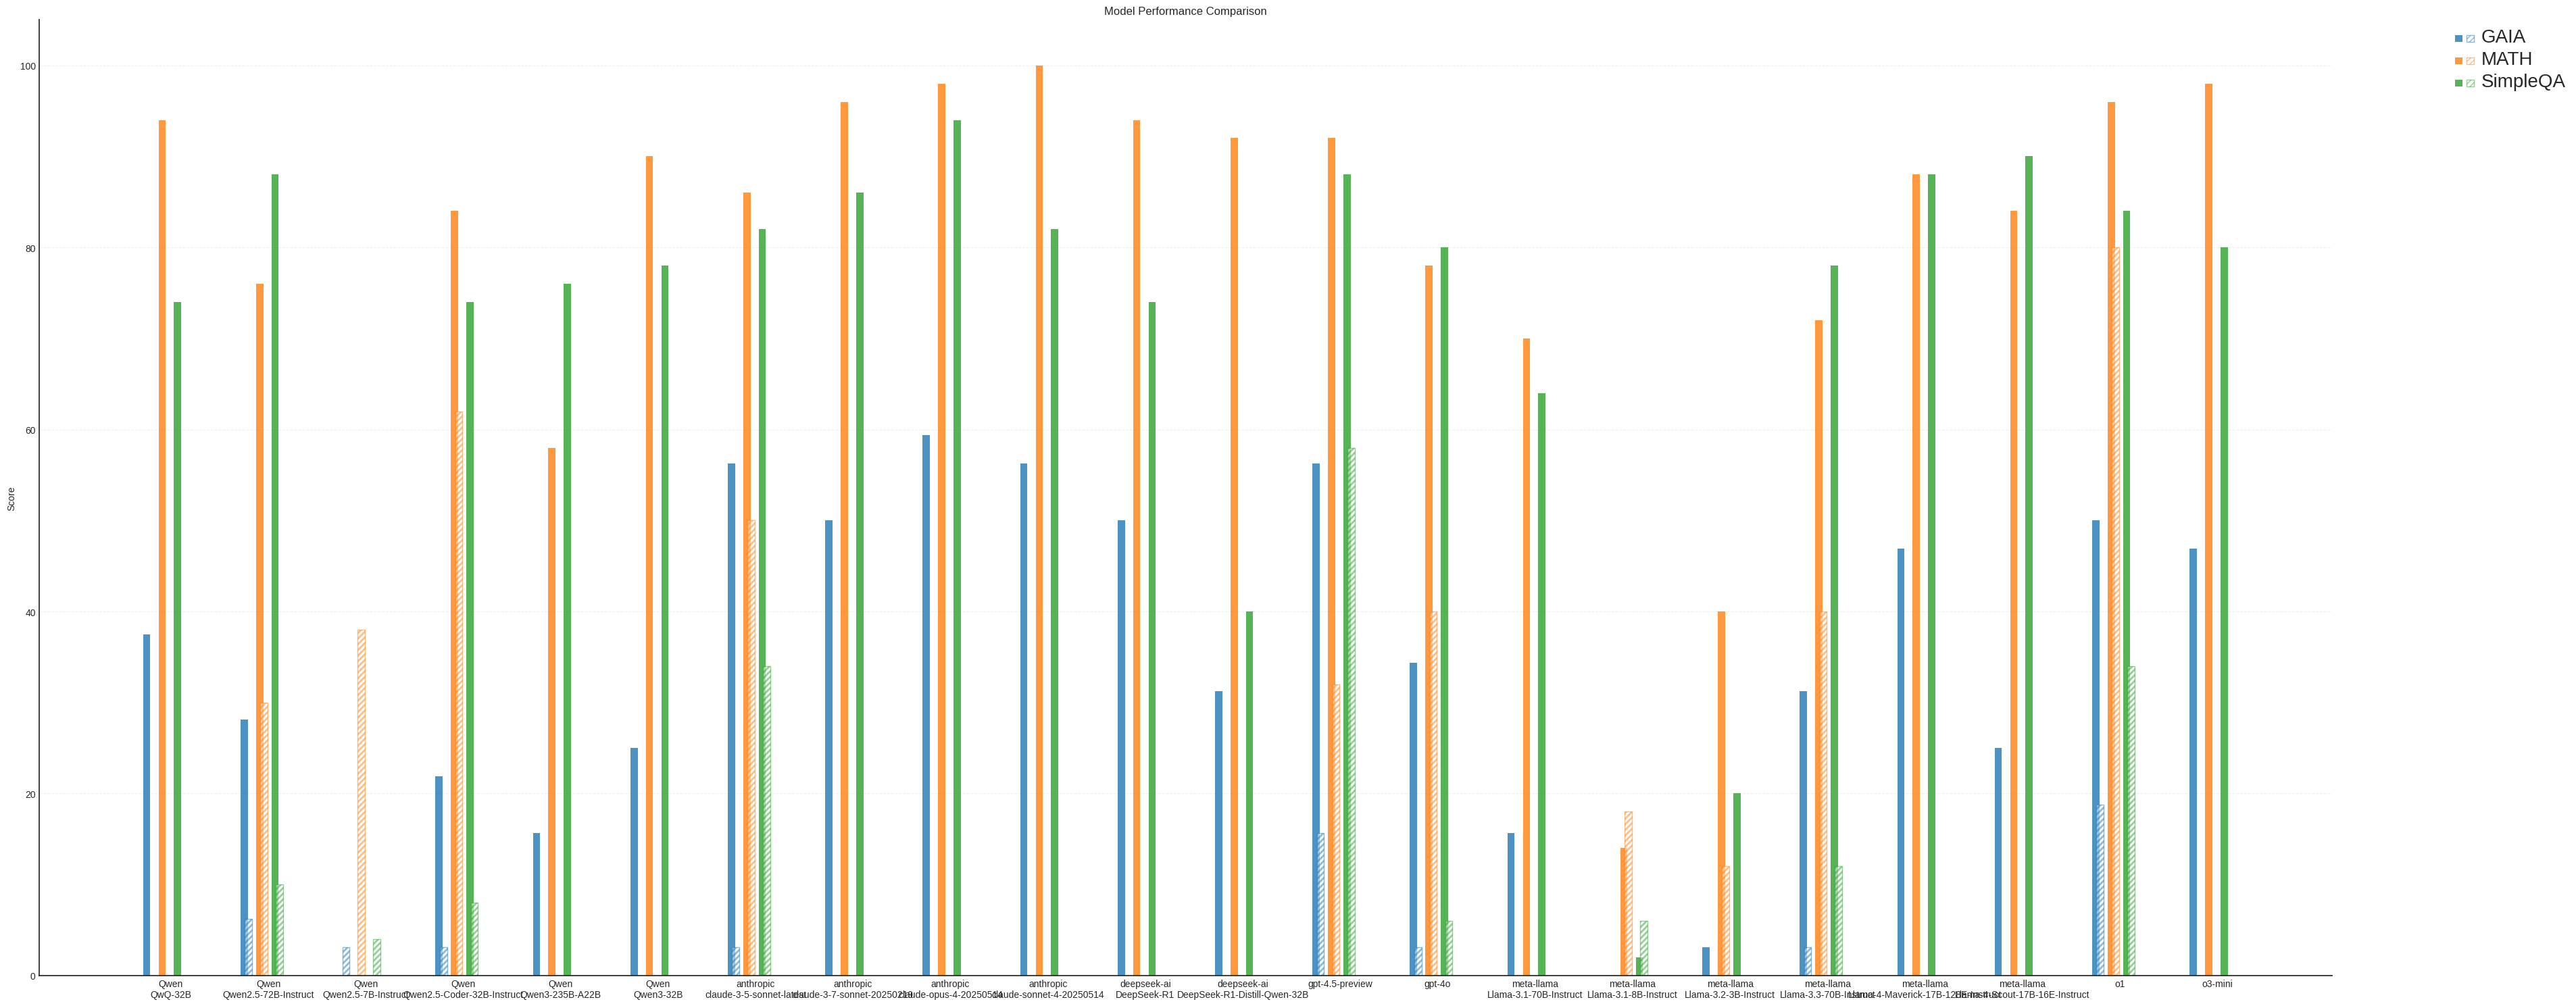

In [8]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple  # Added import


# Assuming pivot_df is your original dataframe
models = pivot_df["model_id"].unique()
sources = pivot_df["source"].unique()

# Create figure and axis
plt.style.use("seaborn-v0_8-white")
fig, ax = plt.subplots(figsize=(38, 15))

# Set the width of each bar group and positions of the bars
width = 0.15  # width of each bar
spacing = 0.02  # space between bars within a group
group_spacing = 1  # space between model groups

# Calculate positions for the bars
num_sources = len(sources)
total_width_per_group = (width + spacing) * num_sources * 2  # *2 for agent and vanilla
x = np.arange(len(models)) * (total_width_per_group + group_spacing)

# Plot bars for each source
for i, source in enumerate(sources):
    source_data = pivot_df[pivot_df["source"] == source]
    agent_scores = [
        source_data[source_data["model_id"] == model]["code"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]
    vanilla_scores = [
        source_data[source_data["model_id"] == model]["vanilla"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]

    # Position calculation for each pair of bars
    pos = x + i * (width * 2 + spacing)

    agent_bars = ax.bar(pos, agent_scores, width, label=f"{source} (Agent)", alpha=0.8)
    vanilla_bars = ax.bar(
        pos + width * 0.6,
        vanilla_scores,
        width,
        hatch="////",
        alpha=0.5,
        hatch_linewidth=2,
        label=f"{source} (Vanilla)",
        color="white",
        edgecolor=agent_bars[0].get_facecolor(),
    )

# Customize the plot
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")

# Set x-axis ticks in the middle of each group
group_centers = x + (total_width_per_group - spacing) / 2
ax.set_xticks(group_centers)

# Wrap long model names to prevent overlap
wrapped_labels = ["\n".join(model.split("/")) for model in models]
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Modify legend to combine agent and vanilla entries
handles, labels = ax.get_legend_handles_labels()
unique_sources = sources
legend_elements = [
    (handles[i * 2], handles[i * 2 + 1], labels[i * 2].replace(" (Agent)", "")) for i in range(len(unique_sources))
]
custom_legend = ax.legend(
    [(agent_handle, vanilla_handle) for agent_handle, vanilla_handle, _ in legend_elements],
    [label for _, _, label in legend_elements],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

for text in custom_legend.get_texts():
    current_size = text.get_fontsize()
    text.set_fontsize(current_size * 2)

ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("model_performance_comparison.png", bbox_inches="tight", dpi=300)
plt.show()

## Todos

- Run one model on the benchmark, as a sanity check.
- Run les modèles de base sur Gaia
- Check agents id dans le système prompt.

- Run les différents benchmarks et regarder les traces. Voir si jamais erreurs d'implémentation.


### Done

- Check timeout tools, the 200 first Fibonacchi number (timeout in the interpreter) ; #OK : Timeout at the trajectory level (kill at more than 5 minutes) #OK - Implemented in the run/py function + in the local_python_executor.py file.
- Make the decentralization in the tools.py rather that in agents.py
- Check if they return well the final answer (is the final_asnwer check is still well implemented or broken ? If yes, reimplement it. For instance, ask to make a tag or a majority vote or global concensus).
- Check if they have one tool to show the traces. If not, create one - We decided to use langfuse as a visualisation tool of the trace (json/html format)



### Next steps
- debug the tests noted in installation.md
- Actualize make tests
- Create a new score.ipynb
- Integrate trl
- Réfléchir sur les méthodes de final answer : avoir en tête que l'on veut avoir plusieurs façons de le faire.



### Meeting of Michal W (July 11th 2025)

This dynamic batching for vllm should be integrated in TRL. So far, not much infos.

Dynamic batching = run several agents and try to batch their code. The issue is when they send it to the API. One of the issue could be that when we send the old batch, one of the old ...

Check the score.ipynb, but with the new model (maybe only a part of this to get time, just for a sanity check).


### Web search tools used:

The repository uses several implementations of a web_search tool:

 -   DuckDuckGoSearchTool – relies on the duckduckgo_search library.

  -  GoogleSearchTool – queries Google via SerpAPI or Serper using requests and API keys.

  -  ApiWebSearchTool – performs searches using Brave’s API.

 -   WebSearchTool – a general tool that can scrape DuckDuckGo or Bing results with plain HTTP requests.

These tools provide markdown-formatted search results for agents in the project.